In [4]:
!pip install scikit-plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('wordnet')


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve

from sklearn.metrics import precision_recall_fscore_support,plot_roc_curve
from sklearn.model_selection import cross_val_score

import scikitplot as skplt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
og_train_df=pd.read_csv('train.csv')
og_test_df=pd.read_csv('test.csv')

In [6]:
train_df=og_train_df.copy(deep=True)
test_df=og_test_df.copy(deep=True)

In [7]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [9]:
# As we can see the below null value for   title, author and text represents fake news

In [10]:
train_df.fillna('',inplace=True)

In [11]:
train_df[train_df.author==''].label.value_counts()

1    1931
0      26
Name: label, dtype: int64

In [12]:
train_df[train_df.title==''].label.value_counts()

1    558
Name: label, dtype: int64

In [13]:
train_df[train_df.text==''].label.value_counts()

1    39
Name: label, dtype: int64

#Let's create features for this pattern

For auhtor column, replace null with 'noauthor' keyword and nonnull values with 'authorpresent' keyword

For title and text replace null  values with 'notitleortext' keywords

In [14]:
def feature_engineer(text,author_flag=False):
    if author_flag:
        if text=='':
            return 'noauthor'
        else:
            return 'authorpresent'
    else:
        if text=='':
            return 'notitleortext'
        else:
            return text        

In [15]:
#create feature for training data
train_df['author']=train_df.author.apply(lambda x: feature_engineer(x,author_flag=True))
train_df['title']=train_df.title.apply(lambda x: feature_engineer(x))
train_df['text']=train_df.text.apply(lambda x: feature_engineer(x))

In [16]:
#check for new features with corresponding target count

In [17]:
train_df[train_df.author=='authorpresent'].label.value_counts()

0    10361
1     8482
Name: label, dtype: int64

In [18]:
train_df[train_df.author=='noauthor'].label.value_counts()

1    1931
0      26
Name: label, dtype: int64

In [19]:
train_df[train_df.title=='notitleortext'].label.value_counts()

1    558
Name: label, dtype: int64

In [20]:
train_df[train_df.text=='notitleortext'].label.value_counts()

1    39
Name: label, dtype: int64

In [21]:
#same processing of features for test data
test_df.fillna('',inplace=True)
test_df['author']=test_df.author.apply(lambda x: feature_engineer(x,author_flag=True))
test_df['title']=test_df.title.apply(lambda x: feature_engineer(x))
test_df['text']=test_df.text.apply(lambda x: feature_engineer(x))

In [22]:
#check for class imbalance on overall data. As we can see no class imbalance
train_df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


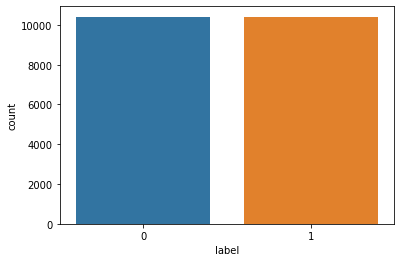

In [23]:
sns.countplot(train_df.label)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


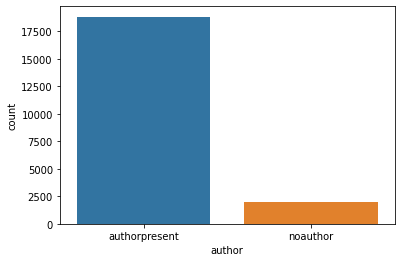

In [24]:
sns.countplot(train_df['author'])

Combine title,text and author to create comined text

In [25]:
train_df['combined_text']=train_df.title+' '+train_df.text+ ' '+ train_df.author
test_df['combined_text']=test_df.title+' '+test_df.text+ ' '+ test_df.author

In [26]:
train_df.loc[5000,'combined_text']

"These 12 Female Activists Are Making The World A Better Place Right Now These women are changing the world as we speak. Credit: Jiri Rezac \nWomen are typically at a disadvantage in nearly every country in the world, but just how much depends on that country’s culture. For some, it’s a struggle of equality in a variety of areas and for others it’s the immense problem of barely being seen as a person, let alone someone with rights. That’s why many women are facing these issues head on and working to make a huge difference in the world as we know it. \nThough many people hear about the female activists that made great strides to get their country to where it is today, people often don’t know about today’s activists. Read about the amazing women below to find out who is advocating for women and humanity around the world. Asieh Amini: Honor Killings Credit: Norsk Literatturfestival \nBorn in northern Iran, the region allowed women to own property, work on farms, and wield social power. Am

In [27]:
#clean text
def clean_text(text_val):
    text = text_val
    text = text.lower()
    text=text.replace('“','').replace('”','').replace('’','')
    text = re.sub('\n', '', text)
    text=''.join([ele for ele in text if ele not in string.punctuation])
    return text


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


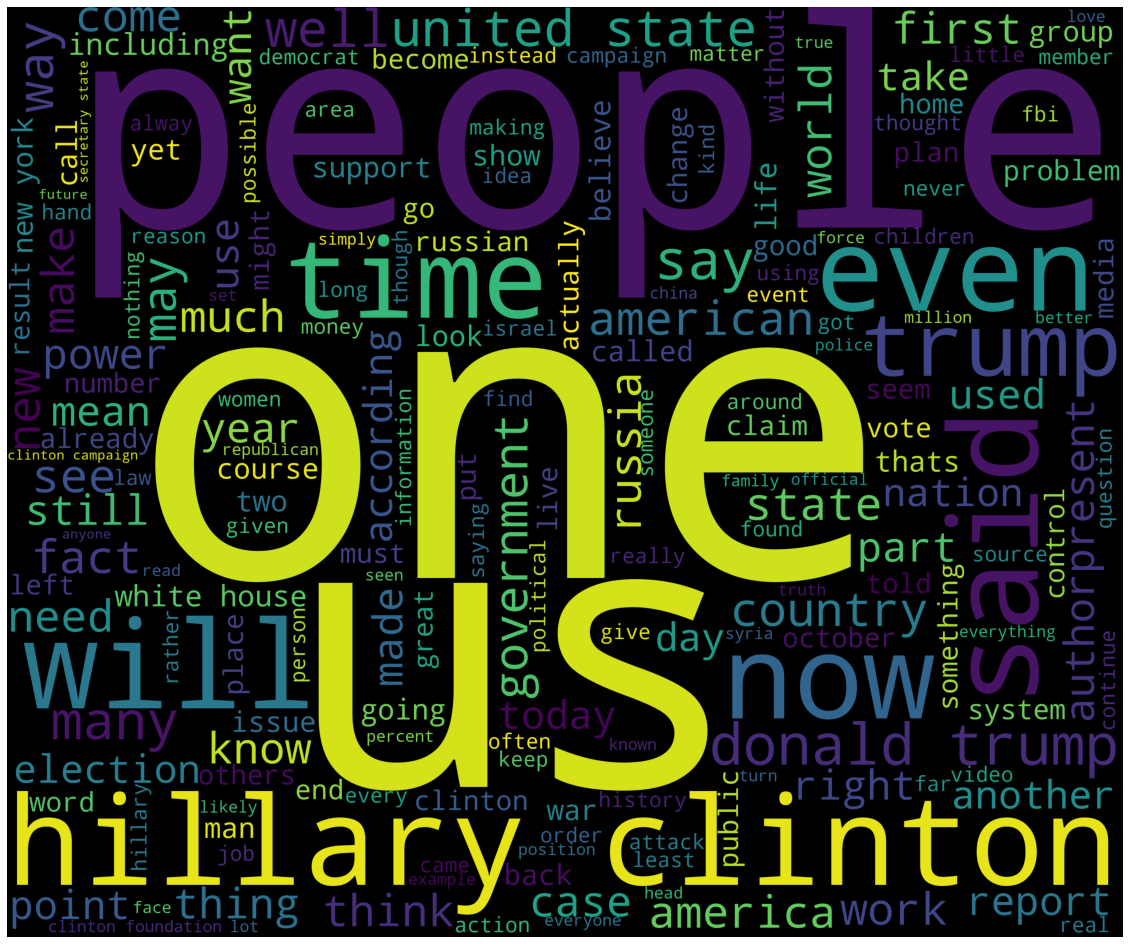

In [28]:
#get word cloud for fakenews
fake_news_df=train_df[train_df['label']==1]
fake_news_df['combined_text']=fake_news_df.combined_text.apply(lambda x : clean_text(x))
words = ' '.join(fake_news_df['combined_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


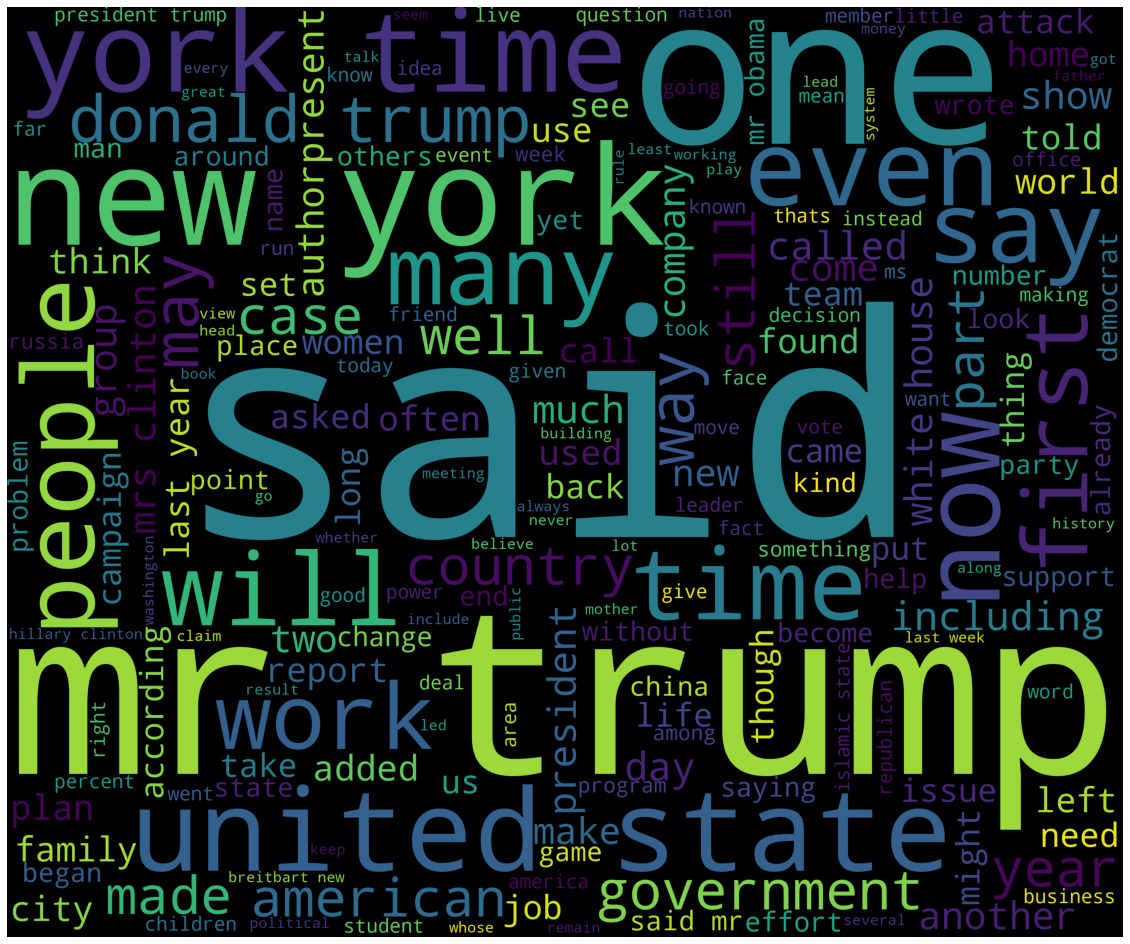

In [29]:
#get word cloud for real news
nonfake_news_df=train_df[train_df['label']==0]
nonfake_news_df['combined_text']=nonfake_news_df.combined_text.apply(lambda x : clean_text(x))
words = ' '.join(nonfake_news_df['combined_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [30]:
#processing of text
lemmatizer = WordNetLemmatizer()
def preprocess_text(text_val):
    text=clean_text(text_val)
    text=' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)  if len(word)>2  and word not in stop_words])
    return text


In [31]:
#process train and test data 
train_df['combined_text']=train_df.combined_text.apply(lambda x: preprocess_text(x))
test_df['combined_text']=test_df.combined_text.apply(lambda x: preprocess_text(x))

Create data for fasttext model

In [32]:
#in fasttext target class starts by __label__+target
train_df['label']='__label__'+train_df['label'].astype(str)
train_df['label']


0        __label__1
1        __label__0
2        __label__1
3        __label__1
4        __label__1
            ...    
20795    __label__0
20796    __label__0
20797    __label__0
20798    __label__1
20799    __label__1
Name: label, Length: 20800, dtype: object

In [33]:
#create train and test data from training dataset
X_train,X_test,y_train,y_test = train_test_split(train_df.combined_text,train_df.label,test_size=0.2, random_state=42,stratify=train_df.label)

In [34]:
#save data as text file in the format required by fasttext
pd.concat([y_test,X_test],axis=1).to_csv('newstest_data.txt', index=False, sep=' ', header=False)
pd.concat([y_train,X_train],axis=1).to_csv('newstrain_data.txt', index=False, sep=' ', header=False)

In [35]:
!pip install fasttext

     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093321 sha256=b6a4768a40ca071df53fb025386ab11cba9708430247944c76f5d41418d693ea
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [36]:
import fasttext
model = fasttext.train_supervised(input="newstrain_data.txt",wordNgrams=3,epoch=25,loss='hs')

In [83]:
#test results on test data
model.test("newstest_data.txt")

(4160, 0.96875, 0.96875)

In [84]:
output_of_test_set_fromtrain=[]
for ele in X_test:
  output_of_test_set_fromtrain.append(model.predict(ele)[0][0])
print(confusion_matrix(y_test.tolist(),output_of_test_set_fromtrain))
print(classification_report(y_test.tolist(),output_of_test_set_fromtrain))


[[2028   49]
 [ 105 1978]]
              precision    recall  f1-score   support

  __label__0       0.95      0.98      0.96      2077
  __label__1       0.98      0.95      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



As we can see we got approx 96 percent precision and recall for class 1 and 0



Perform predictions on Test.csv data provided

In [88]:
output_list=[]
for ele in test_df.combined_text.tolist():
  output_list.append(model.predict(ele))

In [89]:
final_output=[]
for ele in output_list:
  final_output.append((ele[0][0].split('_')[-1]))

In [90]:
test_df['predicted_output']=final_output

In [62]:
test_df[['id','predicted_output']].to_csv('fasttext_results.csv',index=False)

In [63]:
model.save_model("fake_news_prediction_model.bin")


Conclusion:

Fasttext is performing best on both the classes and gives generalized results.

To improve further performance,
We can think of more feature engineering

We can tune more parameters of fasttext and also increase the dimension of vector size for fasttext